## REGRESSÃO NÃO LINEAR E TRANSFORMAÇÃO DE BOX-COX

In [1]:
# Importação dos pacotes
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
from playsound import playsound # reprodução de sons
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

import networkx as nx
import matplotlib.cm as cm

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
df_bebes = pd.read_csv('/home/usp_ds_analytics/regression_analysis/data/bebes.csv', delimiter=',')
df_bebes.head()

comprimento  idade
0        63.07  19.00
1        65.63  21.00
2        65.63  22.50
3        66.73  22.50
4        66.37  23.25

In [3]:
df_bebes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   comprimento  74 non-null     float64
 1   idade        74 non-null     float64
dtypes: float64(2)
memory usage: 1.3 KB


In [4]:
df_bebes.describe()

comprimento      idade
count    74.000000  74.000000
mean     66.921622  25.312162
std      12.852386  12.975168
min      31.900000   2.150000
25%      56.470000  12.500000
50%      70.400000  26.000000
75%      75.807500  33.000000
max      87.630000  60.000000

É importante analisar os dados que temos. Assim, nossa previsão estará apenas dentro do que temos, por exemplo: não podemos prever a idade acima de 60 semanas, pois o nosso dataset vai até 60... Muito menos, idade inferior a 2 semanas, e por aí vai.

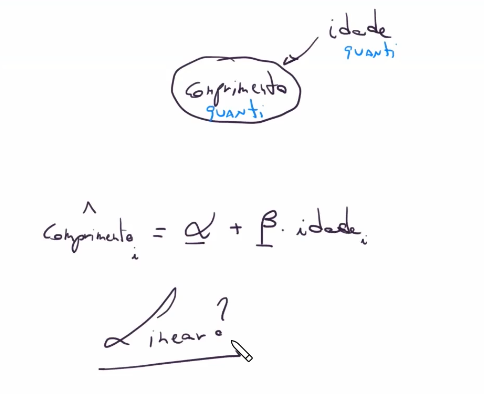

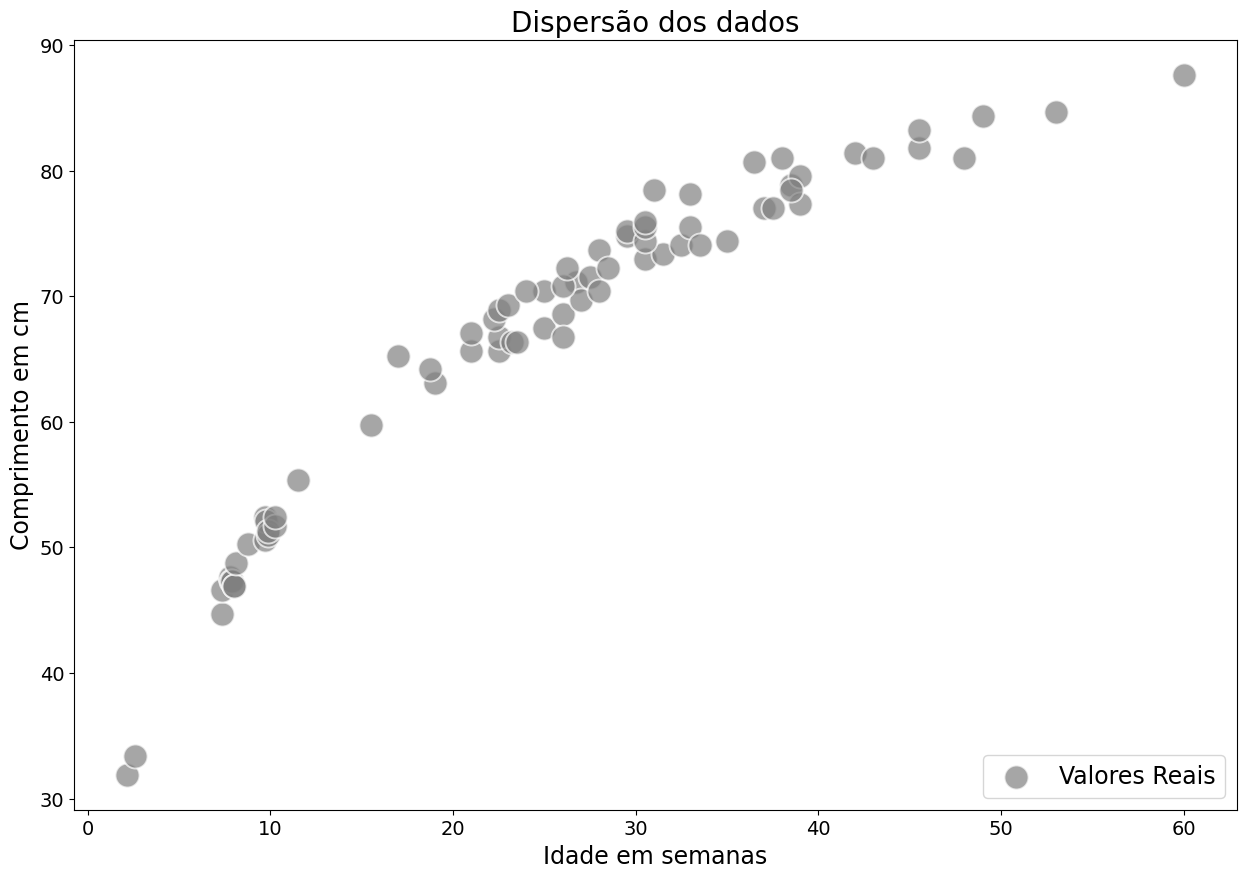

In [5]:
# In[4.1]: Gráfico de dispersão

plt.figure(figsize=(15,10))
sns.scatterplot(x="idade", y="comprimento", data=df_bebes, color='grey',
                s=300, label='Valores Reais', alpha=0.7)
plt.title('Dispersão dos dados', fontsize=20)
plt.xlabel('Idade em semanas', fontsize=17)
plt.ylabel('Comprimento em cm', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

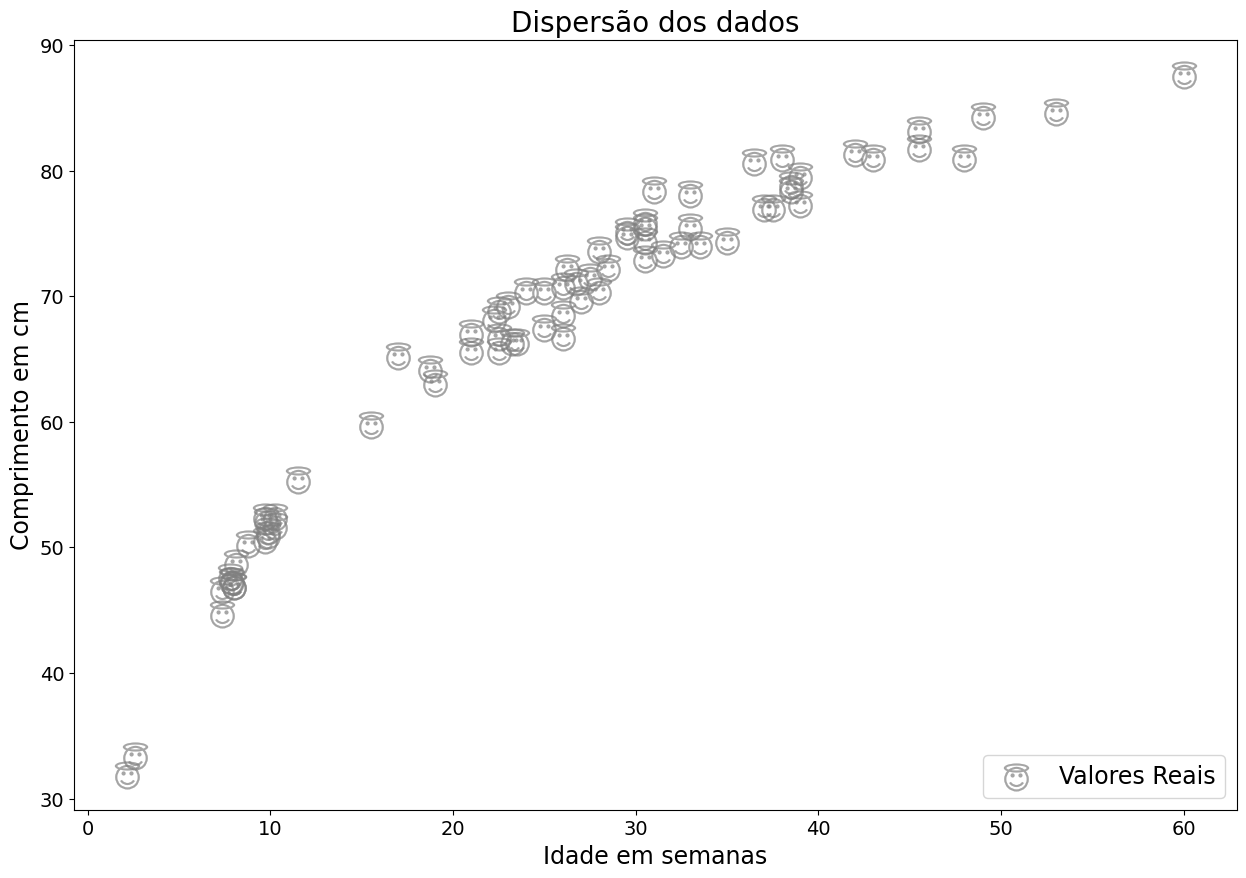

In [6]:
# In[4.2]: Gráfico de dispersão com emojis 01
plt.figure(figsize=(15, 10))
plt.scatter(x="idade", y="comprimento", data=df_bebes, color='grey',
            s=400, label='Valores Reais', alpha=0.7, marker='$\U0001F607$',
            linewidth=0.2)
plt.title('Dispersão dos dados', fontsize=20)
plt.xlabel('Idade em semanas', fontsize=17)
plt.ylabel('Comprimento em cm', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

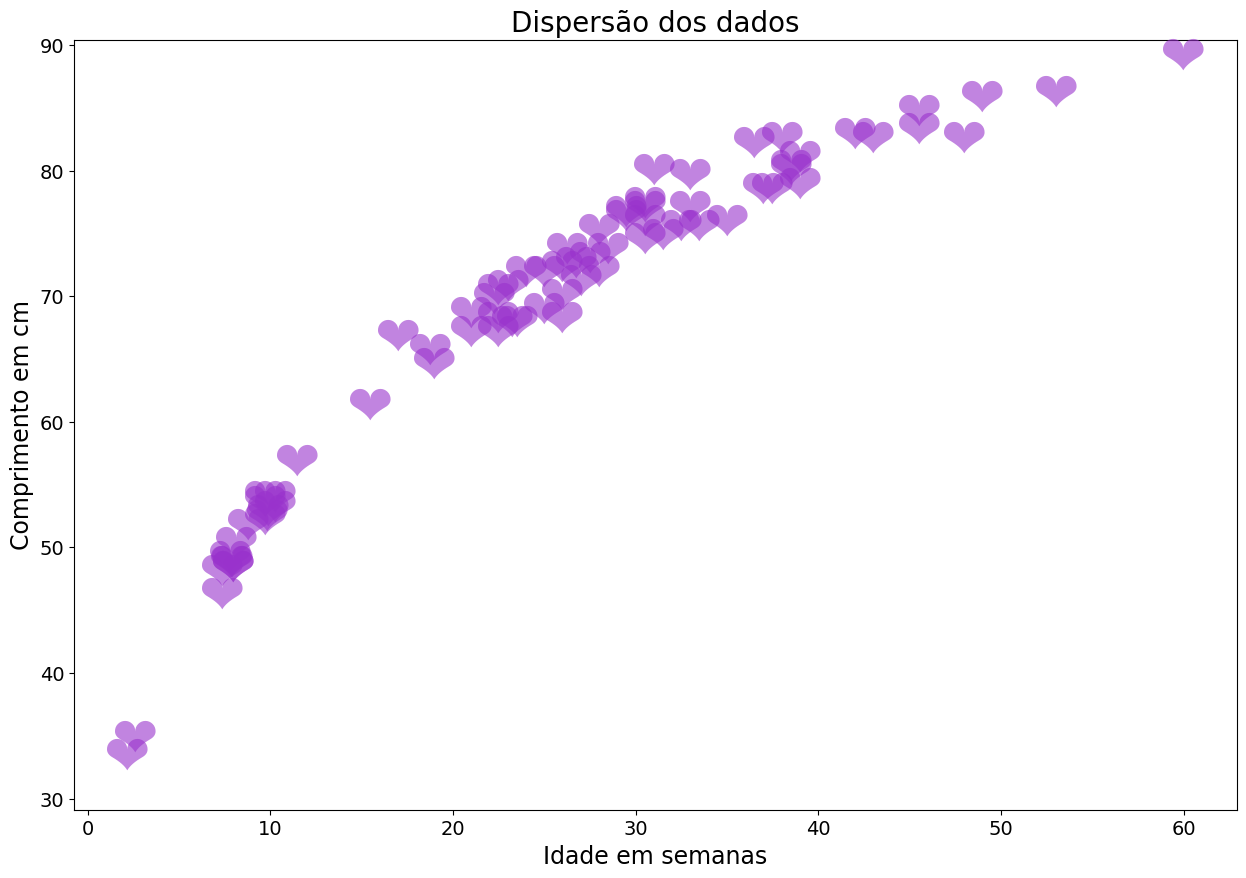

In [7]:
# In[4.3]: Gráfico de dispersão com emojis 02

emojis_coracao = ['❤️'] * len(df_bebes)

plt.figure(figsize=(15, 10))
sns.scatterplot(x="idade", y="comprimento", data=df_bebes, color='none',
                s=0, label=None)
for i, emoji in enumerate(emojis_coracao):
    plt.text(df_bebes['idade'][i], df_bebes['comprimento'][i], emoji,
             fontsize=40, ha='center', alpha=0.6, color='darkorchid')
plt.title('Dispersão dos dados', fontsize=20)
plt.xlabel('Idade em semanas', fontsize=17)
plt.ylabel('Comprimento em cm', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Estimação de um modelo OLS linear

In [8]:
modelo_linear = sm.OLS.from_formula('comprimento ~ idade', df_bebes).fit()

# Parâmetros do 'modelo_linear'
modelo_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            comprimento   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     667.7
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           3.72e-38
Time:                        11:12:05   Log-Likelihood:                -207.26
No. Observations:                  74   AIC:                             418.5
Df Residuals:                      72   BIC:                             423.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.1004      1.034     41.665      0.000      41.038      45.163
idade          0.9411      0.036     25.841      0.000       0.868       1.014
==============================================================================
Omnibus:                       21.203   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.159
Skew:                          -1.218   Prob(JB):                     4.66e-07
Kurtosis:                       4.877   Cond. No.                         62.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

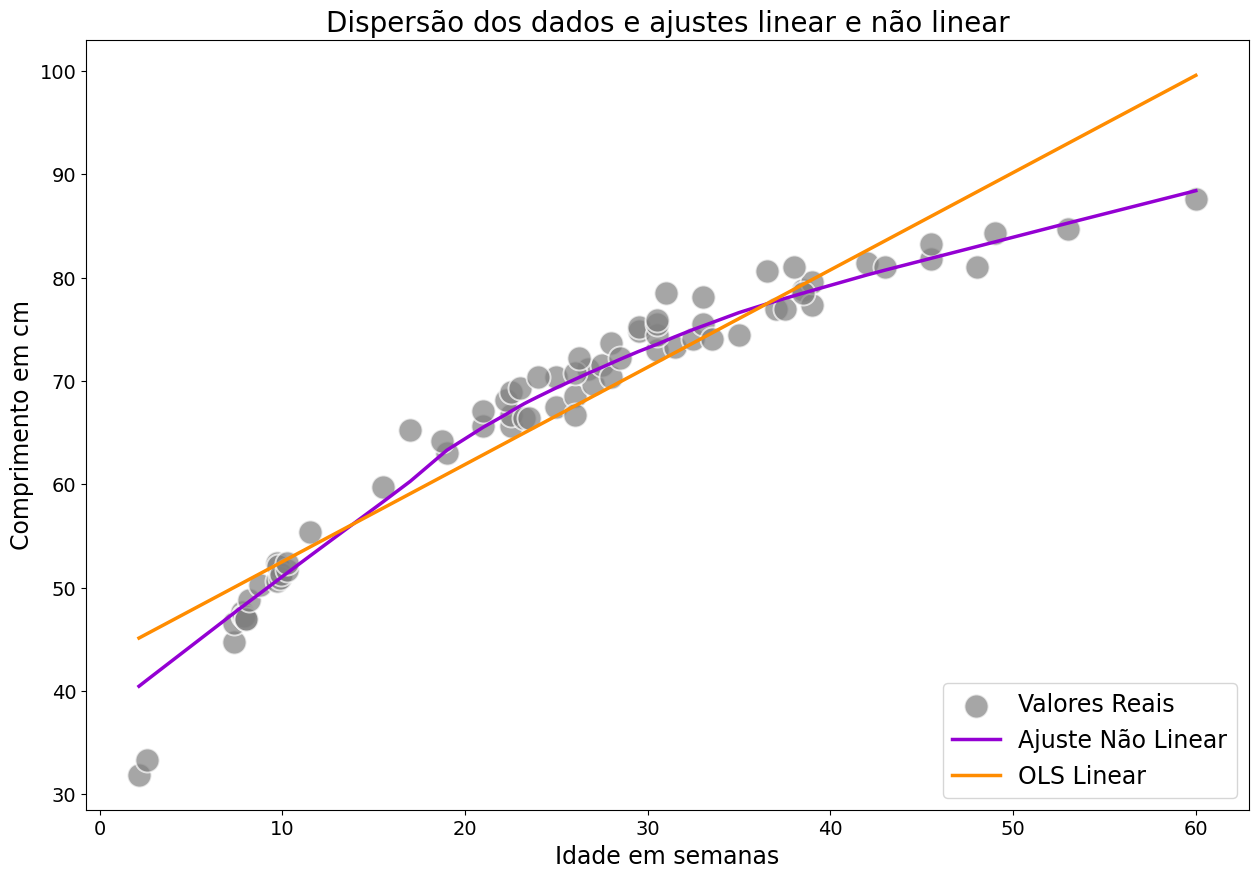

In [9]:
# In[4.5]: Gráfico de dispersão com ajustes (fits) linear e não linear
# com argumento 'lowess=True' (locally weighted scatterplot smoothing)
plt.figure(figsize=(15,10))
sns.scatterplot(x="idade", y="comprimento", data=df_bebes, color='grey',
                s=300, label='Valores Reais', alpha=0.7)
sns.regplot(x="idade", y="comprimento", data=df_bebes, lowess=True,
            color='darkviolet', ci=False, scatter=False, label='Ajuste Não Linear',
            line_kws={'linewidth': 2.5})
sns.regplot(x="idade", y="comprimento", data=df_bebes,
            color='darkorange', ci=False, scatter=False, label='OLS Linear',
            line_kws={'linewidth': 2.5})
plt.title('Dispersão dos dados e ajustes linear e não linear', fontsize=20)
plt.xlabel('Idade em semanas', fontsize=17)
plt.ylabel('Comprimento em cm', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Teste de verificação da aderência dos resíduos à normalidade

- Teste de Shapiro-Wilk (n < 30)
    - from scipy.stats import shapiro
    - shapiro(modelo_linear.resid)

- Teste de Shapiro-Francia (n >= 30)
    - Carregamento da função 'shapiro_francia' do pacote 'statstests.tests'
    - Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
    - https://stats-tests.github.io/statstests/

In [10]:
from statstests.tests import shapiro_francia

# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_linear.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
# tupla é usada para aglomerar dados heterogêneos, valores não podem ser alterados
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9087044262594457
statistics z  :  3.6276504915453827
p-value  :  0.00014300603555437503
Statistics W=0.90870, p-value=0.000143
Rejeita-se H0 - Distribuição não aderente à normalidade


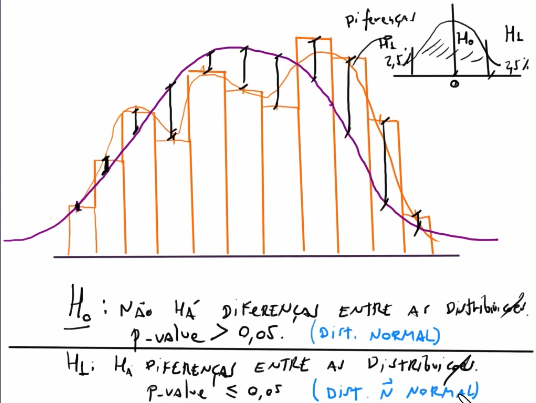

> [!warning] Cuidado com o que você está avaliando no teste, e o resultado do p-value.

Neste caso aqui, estamos avaliando se a distribuição têm aderência à normalidade, ou seja, os termos de erro, não quero que seja estatísticamente diferente, então verificamos se o p-value > 0.05 (95% nível de confiança).

### Histograma dos resíduos do modelo OLS linear

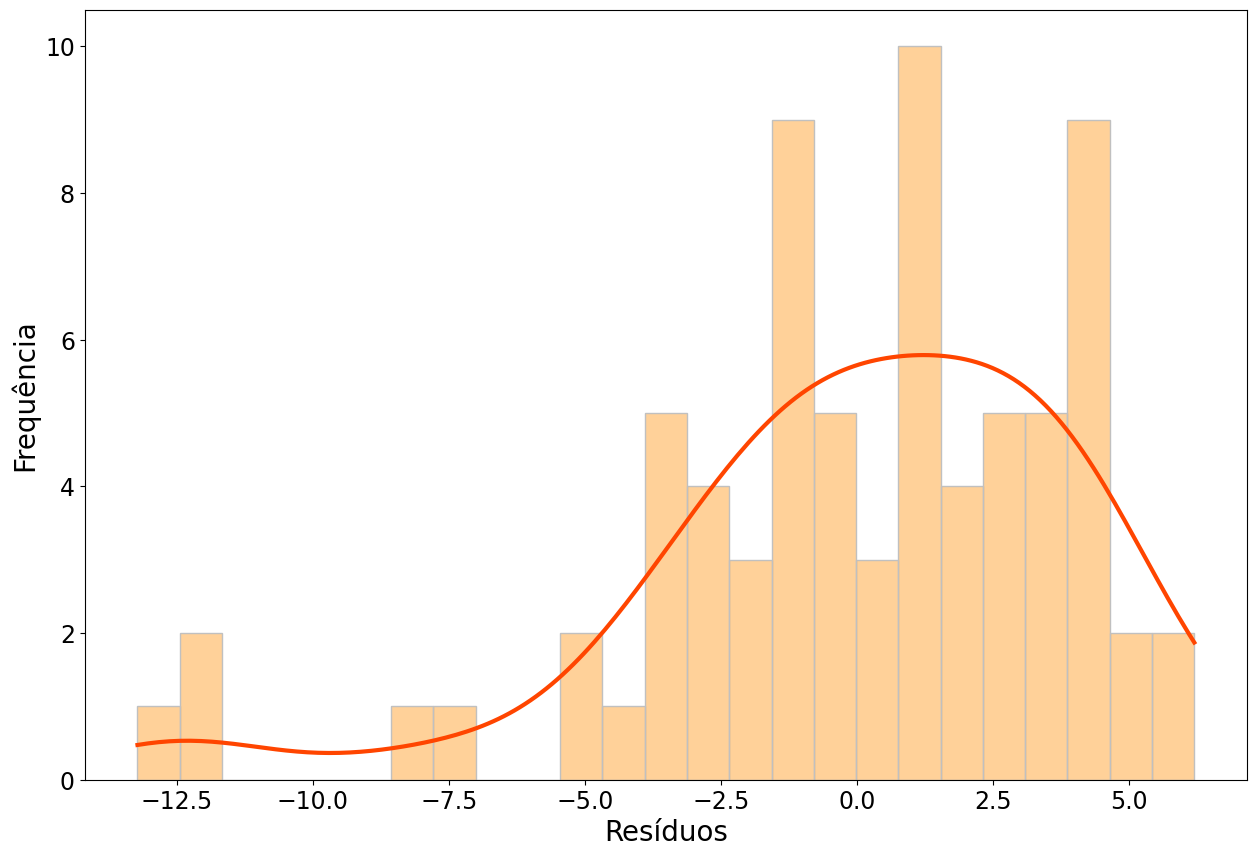

In [11]:
plt.figure(figsize=(15,10))
hist1 = sns.histplot(data=modelo_linear.resid, kde=True, bins=25,
                     color = 'darkorange', alpha=0.4, edgecolor='silver',
                     line_kws={'linewidth': 3})
hist1.get_lines()[0].set_color('orangered')
plt.xlabel('Resíduos', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

#### Diferenças entre Padronização e Normalização

Escala e Distribuição:
- Padronização ajusta os dados para que tenham média 0 e desvio padrão 1, mantendo a distribuição original dos dados, mas centrando-os.
- Normalização reescala os dados para um intervalo fixo, o que pode distorcer a distribuição original, mas garante que todos os dados estejam dentro de um intervalo específico.

Uso Comum:
- Padronização é preferida quando os dados seguem uma distribuição normal ou quando é importante manter a forma da distribuição original.
- Normalização é usada quando a escala dos dados é importante (por exemplo, em modelos baseados em distâncias ou em situações onde a escala absoluta é relevante).

Resultado Final:
- Padronização pode resultar em valores fora de um intervalo específico (como valores extremos muito menores ou maiores que -1 e 1).
- Normalização garante que todos os valores estejam dentro de um intervalo predefinido, sem exceções.

>[!warning] Padronização não altera a distribuição!

> [!warning] Padronização não é normalização

In [24]:
# Padronização pelo procedimento z-score da variável Y (comprimento)
from scipy.stats import zscore

df_bebes['zcomprimento'] = zscore(df_bebes['comprimento'])
df_bebes['zcomprimento'].describe()

count    7.400000e+01
mean    -2.655533e-16
std      1.006826e+00
min     -2.743512e+00
25%     -8.187557e-01
50%      2.724881e-01
75%      6.960990e-01
max      1.622246e+00
Name: zcomprimento, dtype: float64

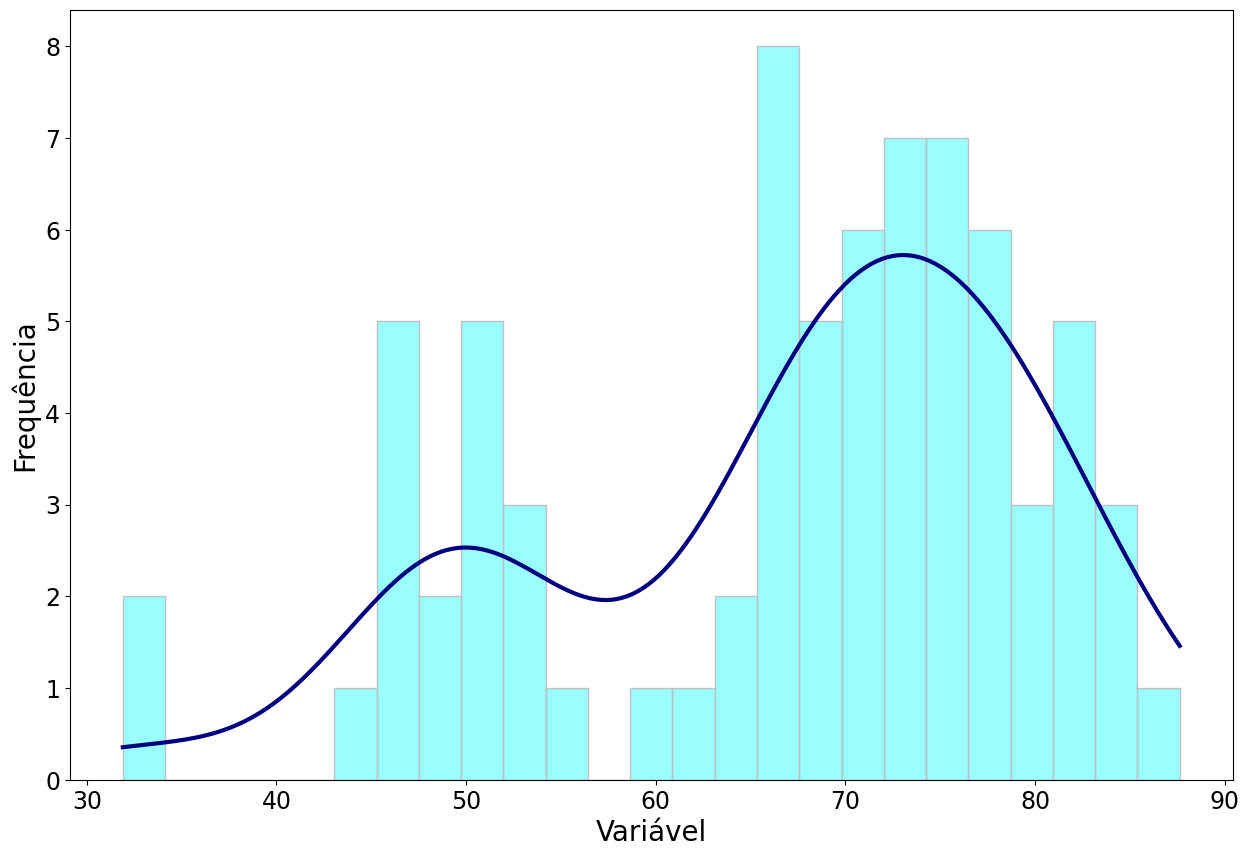

In [25]:
# Histograma da variável original 'comprimento'

plt.figure(figsize=(15,10))
hist1 = sns.histplot(data=df_bebes['comprimento'], kde=True, bins=25,
                     color = 'aqua', alpha=0.4, edgecolor='silver',
                     line_kws={'linewidth': 3})
hist1.get_lines()[0].set_color('navy')
plt.xlabel('Variável', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

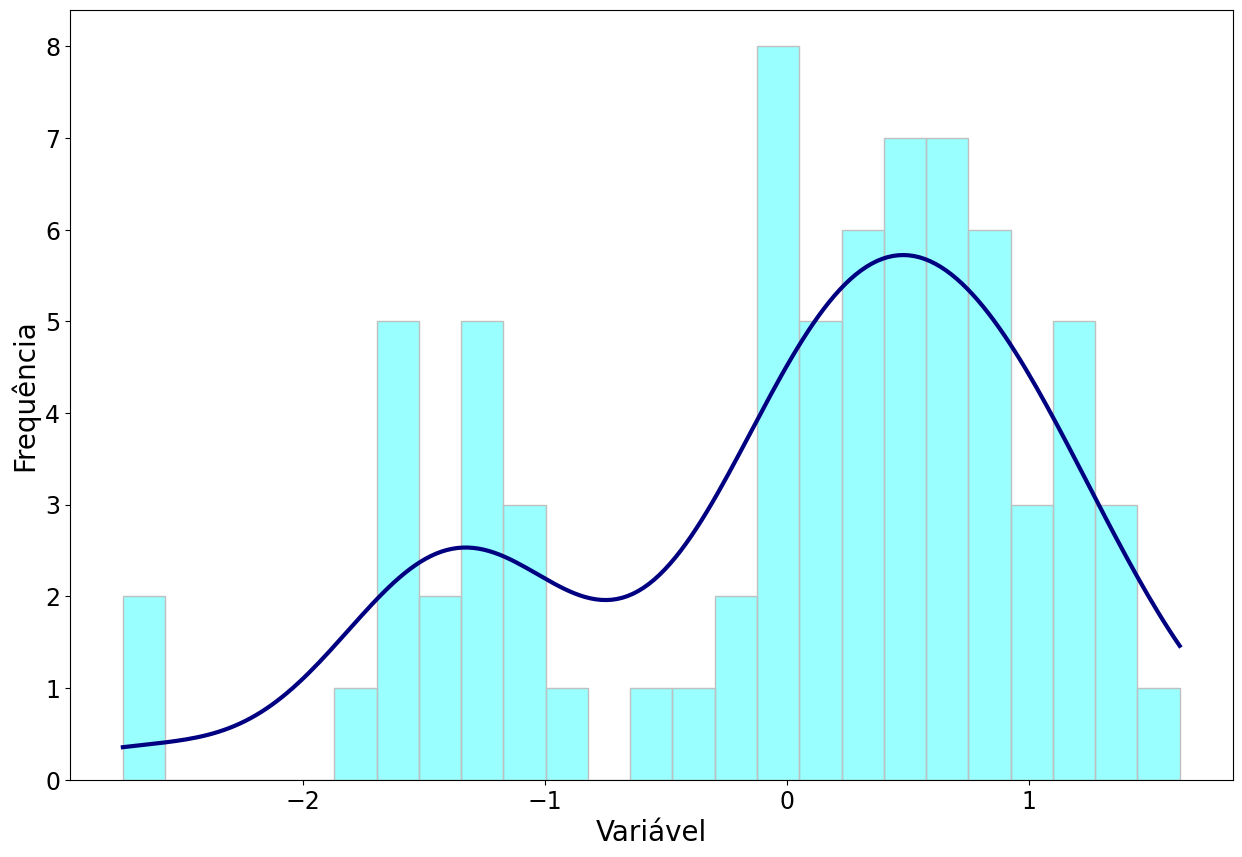

In [26]:
# Histograma da variável original 'zcomprimento'
plt.figure(figsize=(15,10))
hist1 = sns.histplot(data=df_bebes['zcomprimento'], kde=True, bins=25,
                     color = 'aqua', alpha=0.4, edgecolor='silver',
                     line_kws={'linewidth': 3})
hist1.get_lines()[0].set_color('navy')
plt.xlabel('Variável', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

Ops, não mudou nada! Realmente a padronização (zscore) não altera a distribuição.

In [27]:
# Teste de Shapiro-Francia da variável 'comprimento'
teste_sf = shapiro_francia(df_bebes['comprimento']) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9242393179099305
statistics z  :  3.2661109119327003
p-value  :  0.0005451776708206652
Statistics W=0.92424, p-value=0.000545
Rejeita-se H0 - Distribuição não aderente à normalidade


In [28]:
# Teste de Shapiro-Francia da variável 'zcomprimento'
teste_sf = shapiro_francia(df_bebes['zcomprimento']) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9242393179099307
statistics z  :  3.266110911932695
p-value  :  0.0005451776708206756
Statistics W=0.92424, p-value=0.000545
Rejeita-se H0 - Distribuição não aderente à normalidade


Mesmo no método Shapiro-Francia com os dados padronizados, o teste acusou a não aderência à normalidade.

Tá em dúvida, faça os testes

### Transformação de Box-Cox

Para que muitos modelos estatísticos, como a regressão linear, sejam confiáveis, é necessário que os resíduos do modelo sigam uma distribuição normal e que a variância dos resíduos seja constante ao longo dos valores previstos.

A transformação de Box-Cox é uma família de transformações paramétricas que ajusta os dados com base em um parâmetro $\lambda$. Dependendo do valor de $\lambda$, a transformação pode ser, por exemplo, uma raiz quadrada, um logaritmo ou nenhuma transformação, entre outras. O objetivo é encontrar o valor de $\lambda$ que melhor "normaliza" os dados e minimiza a heterocedasticidade.

Para um aprendiz de cientista de dados, a aplicação da transformação de Box-Cox pode ser muito útil em modelos que inicialmente não apresentam uma boa adequação, porque:

- Melhora a linearidade: Muitos modelos de regressão assumem que a relação entre as variáveis é linear. A transformação de Box-Cox pode ajudar a linearizar relações que originalmente são não lineares.

- Normalidade dos resíduos: A transformação pode ajudar a tornar os resíduos mais próximos de uma distribuição normal, o que é uma suposição fundamental para a validade de muitos testes estatísticos e intervalos de confiança.

- Redução da heterocedasticidade: A variância dos resíduos pode variar ao longo dos valores previstos, violando a suposição de homocedasticidade. A transformação pode ajudar a estabilizar a variância, resultando em estimativas mais confiáveis.

- Melhoria da previsão: Modelos que atendem melhor às suas suposições produzem previsões mais precisas e generalizáveis.

Em resumo, a transformação de Box-Cox é uma ferramenta poderosa que ajuda a melhorar a adequação de um modelo ao tratar de problemas relacionados à não linearidade, normalidade dos resíduos e heterocedasticidade, o que, por sua vez, melhora a análise e a predição de resultados.

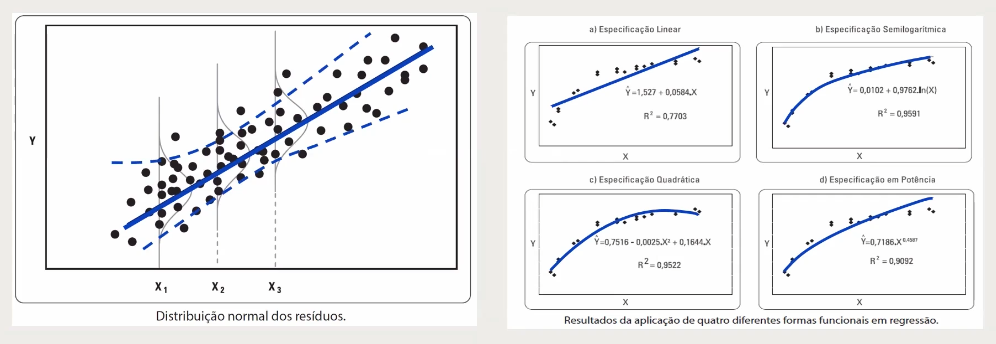

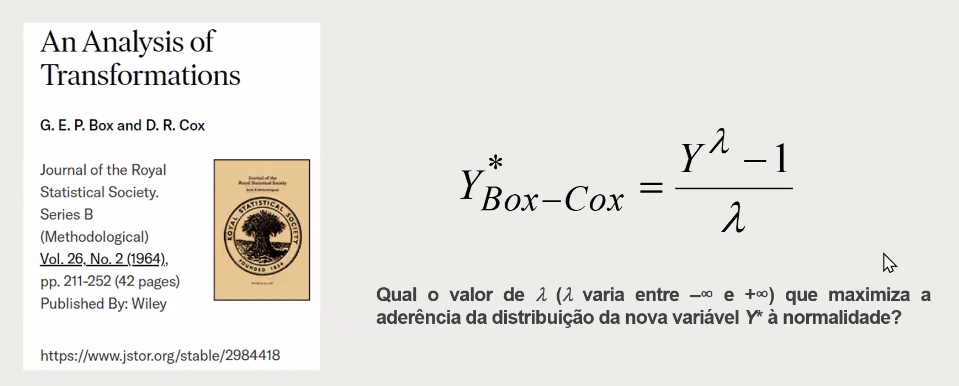

In [12]:
# Para o cálculo do lambda de Box-Cox
from scipy.stats import boxcox

# 'yast' é uma variável que traz os valores transformados (Y*)
# 'lmbda' é o lambda de Box-Cox
yast, lmbda = boxcox(df_bebes['comprimento'])

# Inserção da variável transformada ('bc_comprimento') no dataset para a
#estimação de um novo modelo
df_bebes['bc_comprimento'] = yast

df_bebes.head()

comprimento  idade  bc_comprimento
0        63.07  19.00    22966.092606
1        65.63  21.00    25529.075884
2        65.63  22.50    25529.075884
3        66.73  22.50    26682.733457
4        66.37  23.25    26301.668594

In [31]:
print(lmbda)

2.659051117199506


In [32]:
print(yast)

[22966.09260608 25529.07588389 25529.07588389 26682.73345692
 26301.66859415 26301.66859415 27476.80597168 30765.08705745
 28684.16297061 31620.68244162 29924.08483644 32059.9448889
 30765.08705745 34750.42526581 33842.66407674 34288.45358969
 35216.26078559 37092.37352805 40543.86354107 35216.26078559
 35673.22691852 39043.10969206 39043.10969206 41559.38445661
 39543.9690118  42604.86409935 45260.32451956 44715.33733929
 45809.43706308 48016.70023264 44715.33733929 49722.72075889
 50304.93626793 55065.99322907  3748.74624183  4225.87541684
  9210.48343169 10252.67378671 10909.32773481 10685.61239497
 10685.61239497 10464.78163006 10464.78163006 11591.6082333
 12537.42436425 12784.50373169 14051.16818153 13796.07642351
 13034.59877794 13280.84282814 13536.93026254 14051.16818153
 16244.98554484 19907.87457147 25158.40366788 24046.66205516
 27077.95362797 28274.43448967 29086.35399376 29503.36430247
 30765.08705745 26682.73345692 31196.91493126 32937.71788873
 32937.71788873 36146.7231

In [13]:
# Verificação do cálculo, apenas para fins didáticos
df_bebes['bc_comprimento2'] = ((df_bebes['comprimento']**lmbda)-1)/lmbda

df_bebes.head()

comprimento  idade  bc_comprimento  bc_comprimento2
0        63.07  19.00    22966.092606     22966.092606
1        65.63  21.00    25529.075884     25529.075884
2        65.63  22.50    25529.075884     25529.075884
3        66.73  22.50    26682.733457     26682.733457
4        66.37  23.25    26301.668594     26301.668594

In [14]:
del df_bebes['bc_comprimento2']

### Estimando um novo modelo OLS com variável dependente transformada por Box-Cox

In [15]:
modelo_bc = sm.OLS.from_formula('bc_comprimento ~ idade', df_bebes).fit()

# Parâmetros do 'modelo_bc'
modelo_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         bc_comprimento   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1822.
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           7.16e-53
Time:                        11:19:22   Log-Likelihood:                -681.77
No. Observations:                  74   AIC:                             1368.
Df Residuals:                      72   BIC:                             1372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4995.1615    630.253      7.926      0.000    3738.775    6251.548
idade        947.2302     22.189     42.689      0.000     902.997     991.463
==============================================================================
Omnibus:                        1.140   Durbin-Watson:                   0.813
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                0.557
Skew:                           0.098   Prob(JB):                        0.757
Kurtosis:                       3.377   Cond. No.                         62.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Comparando os parâmetros do 'modelo_linear' com os do 'modelo_bc'
> [!warning] OS PARÂMETROS NÃO SÃO DIRETAMENTE COMPARÁVEIS!


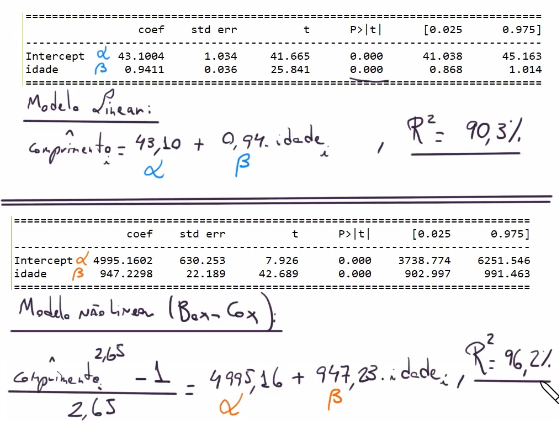

In [16]:
summary_col([modelo_linear, modelo_bc])

# Outro modo mais completo também pela função 'summary_col'
summary_col([modelo_linear, modelo_bc],
            model_names=["MODELO LINEAR","MODELO BOX-COX"],
            stars=True,
            info_dict = {
                'N':lambda x: "{0:d}".format(int(x.nobs))
        })

# Repare que há um salto na qualidade do ajuste para o modelo não linear (R²)

pd.DataFrame({'R² OLS':[round(modelo_linear.rsquared,4)],
              'R² Box-Cox':[round(modelo_bc.rsquared,4)]})

R² OLS  R² Box-Cox
0  0.9027       0.962

### Verificando a normalidade dos resíduos do 'modelo_bc'

In [17]:
# Teste de Shapiro-Francia: interpretação
teste_sf = shapiro_francia(modelo_bc.resid) #criação do objeto 'teste_sf'
teste_sf = teste_sf.items() #retorna o grupo de pares de valores-chave no dicionário
method, statistics_W, statistics_z, p = teste_sf #definição dos elementos da lista (tupla)
print('Statistics W=%.5f, p-value=%.6f' % (statistics_W[1], p[1]))
alpha = 0.05 #nível de significância
if p[1] > alpha:
	print('Não se rejeita H0 - Distribuição aderente à normalidade')
else:
	print('Rejeita-se H0 - Distribuição não aderente à normalidade')

method  :  Shapiro-Francia normality test
statistics W  :  0.9729952064687977
statistics z  :  1.2666154523890727
p-value  :  0.10264641223384502
Statistics W=0.97300, p-value=0.102646
Não se rejeita H0 - Distribuição aderente à normalidade


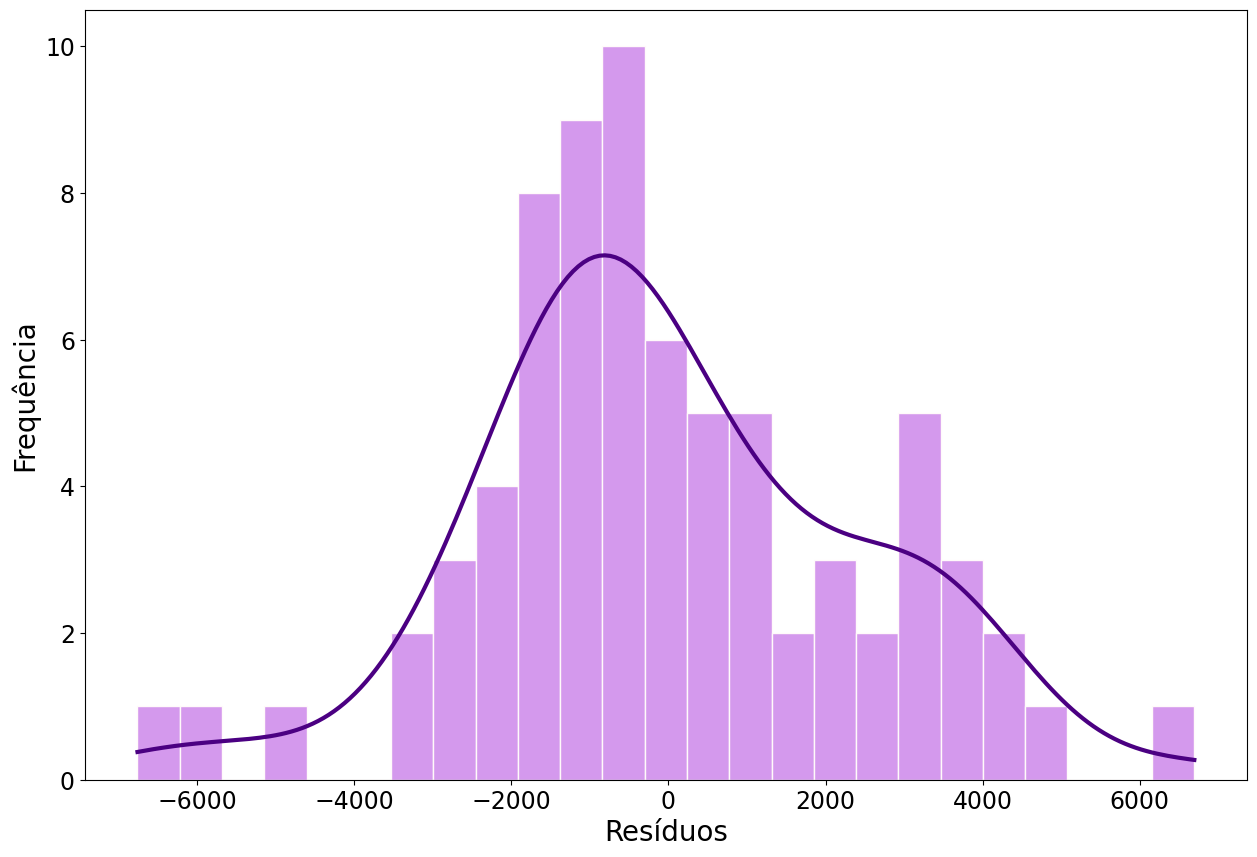

In [18]:
# In[4.12]: Histograma dos resíduos do modelo_bc
plt.figure(figsize=(15,10))
hist2 = sns.histplot(data=modelo_bc.resid, kde=True, bins=25,
                     color='darkviolet', alpha=0.4, edgecolor='snow',
                     line_kws={'linewidth': 3})
hist2.get_lines()[0].set_color('indigo')
plt.xlabel('Resíduos', fontsize=20)
plt.ylabel('Frequência', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.show()

### Fazendo predições com os modelos OLS linear e Box-Cox
Qual é o comprimento esperado de um bebê com 52 semanas de vida?


In [35]:
# Modelo OLS Linear:
# Lembre-se de trabalhar dentro dos limites dos dados apresentados
modelo_linear.predict(pd.DataFrame({'idade':[52]}))

0    92.037486
dtype: float64

In [36]:
# Modelo Não Linear (Box-Cox):
modelo_bc.predict(pd.DataFrame({'idade':[52]}))

0    54251.133574
dtype: float64

In [37]:
# Não podemos nos esquecer de fazer o cálculo inverso para a obtenção do fitted
#value de Y (variável 'comprimento')
(54251.109775 * lmbda + 1) ** (1 / lmbda)

np.float64(87.14005015040935)

Ajustado, o modelo mostrou que com 52 semanas, o bebê teria 87.14cm, não 92.03cm como mostrou o modelo linear acima.

In [38]:
# In[4.14]: Salvando os fitted values dos dois modelos (modelo_linear e modelo_bc)
#no dataset 'bebes'
df_bebes['yhat_linear'] = modelo_linear.fittedvalues
df_bebes['yhat_modelo_bc'] = (modelo_bc.fittedvalues * lmbda + 1) ** (1 / lmbda)
df_bebes.head(10)

comprimento  idade  bc_comprimento  yhat_linear  yhat_modelo_bc  \
0        63.07  19.00    22966.092606    60.981260       63.097300   
1        65.63  21.00    25529.075884    62.863455       65.004303   
2        65.63  22.50    25529.075884    64.275102       66.375858   
3        66.73  22.50    26682.733457    64.275102       66.375858   
4        66.37  23.25    26301.668594    64.980925       67.044337   
5        66.37  23.50    26301.668594    65.216200       67.264723   
6        67.47  25.00    27476.805972    66.627847       68.562586   
7        70.40  25.00    30765.087057    66.627847       68.562586   
8        68.57  26.00    28684.162971    67.568944       69.405676   
9        71.13  26.75    31620.682442    68.274768       70.027015   

   zcomprimento  
0     -0.301727  
1     -0.101183  
2     -0.101183  
3     -0.015011  
4     -0.043213  
5     -0.043213  
6      0.042959  
7      0.272488  
8      0.129130  
9      0.329675

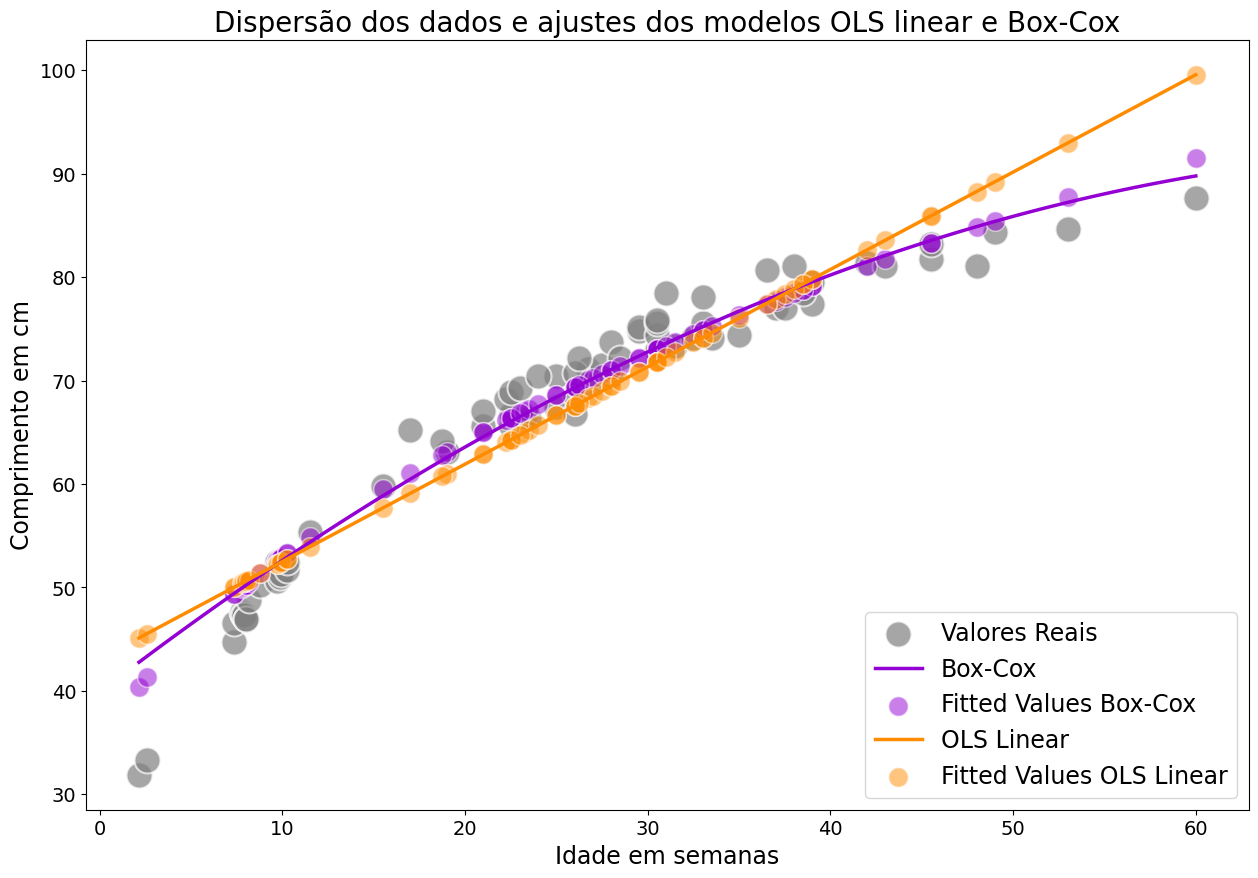

In [21]:
# In[4.15]: Gráfico de dispersão com ajustes dos modelos OLS linear e Box-Cox

plt.figure(figsize=(15,10))
sns.scatterplot(x="idade", y="comprimento", data=df_bebes, color='grey',
                s=350, label='Valores Reais', alpha=0.7)
sns.regplot(x="idade", y="yhat_modelo_bc", data=df_bebes, order=lmbda,
            color='darkviolet', ci=False, scatter=False, label='Box-Cox',
            line_kws={'linewidth': 2.5})
sns.scatterplot(x="idade", y="yhat_modelo_bc", data=df_bebes, color='darkviolet',
                s=200, label='Fitted Values Box-Cox', alpha=0.5)
sns.regplot(x="idade", y="yhat_linear", data=df_bebes,
            color='darkorange', ci=False, scatter=False, label='OLS Linear',
            line_kws={'linewidth': 2.5})
sns.scatterplot(x="idade", y="yhat_linear", data=df_bebes, color='darkorange',
                s=200, label='Fitted Values OLS Linear', alpha=0.5)
plt.title('Dispersão dos dados e ajustes dos modelos OLS linear e Box-Cox',
          fontsize=20)
plt.xlabel('Idade em semanas', fontsize=17)
plt.ylabel('Comprimento em cm', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [23]:
# In[4.16]: Gráfico de dispersão com ajustes dos modelos OLS linear e Box-Cox,
#com interação (figura 'EXEMPLO4.html' salva na pasta do curso)

# Ajuste polinomial com grau igual a lambda (lmbda = 2.659051008426254)
coefficients = np.polyfit(df_bebes["idade"], df_bebes["yhat_modelo_bc"], lmbda)
x_range = np.linspace(df_bebes["idade"].min(), df_bebes["idade"].max(), 100)
y_quadratic = np.polyval(coefficients, x_range)

fig = go.Figure()

fig.add_trace(go.Scatter(x=df_bebes["idade"], y=df_bebes["comprimento"],
                         mode='markers',
                         marker=dict(color='grey', opacity=0.7, size=20),
                         name='Valores Reais'))

fig.add_trace(go.Scatter(x=x_range, y=y_quadratic,
                         mode='lines',
                         line=dict(color='darkviolet', width=2),
                         name='Box-Cox'))

fig.add_trace(go.Scatter(x=df_bebes["idade"], y=df_bebes["yhat_modelo_bc"],
                         mode='markers',
                         marker=dict(color='darkviolet', opacity=0.5, size=15),
                         name='Fitted Values Box-Cox',
                         hovertemplate='Fitted Values Box-Cox: %{y:.2f}<extra></extra>'))

fig.add_trace(go.Scatter(x=df_bebes["idade"], y=df_bebes["yhat_linear"],
                         mode='lines',
                         marker=dict(color='darkorange'),
                         name='OLS Linear',
                         hovertemplate='Fitted Values OLS Linear: %{y:.2f}<extra></extra>'))

fig.add_trace(go.Scatter(x=df_bebes["idade"], y=df_bebes["yhat_linear"],
                         mode='markers',
                         marker=dict(color='darkorange', opacity=0.5, size=15),
                         name='Fitted Values OLS Linear',
                         hovertemplate='Fitted Values OLS Linear: %{y:.2f}<extra></extra>'))

fig.update_layout(title={
        'text': 'Dispersão dos dados e ajustes dos modelos OLS linear e Box-Cox',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'},
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Idade em semanas',
    yaxis_title='Comprimento em cm',
    legend=dict(x=1.02, y=1),
    template='plotly_white')

fig.update_annotations(dict(xref="x", yref="y"))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')


fig.show()

#fig.write_html("EXEMPLO4.html")

# Abre o arquivo HTML no browser
#import webbrowser
#webbrowser.open('EXEMPLO4.html')